In [6]:
import cvxpy as cp
import numpy as np
import pandas as pd
import yfinance as yf
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import norm

data = yf.download('TSLA', start = '2021-01-18', end = '2022-01-18')

Prices = pd.DataFrame(data['Adj Close'])
return_for_Prices = Prices.pct_change(1).dropna()

N = len(Prices) #days

#constraint set of gamma
max_X = return_for_Prices.max()
min_X = return_for_Prices.min()
max_gamma = 1/abs(float(min_X))
min_gamma = -1/float(max_X)
print(max_X, min_X)
print(max_gamma, min_gamma)
price_list = data['Adj Close'].tolist()
print('from', price_list[0], 'to', price_list[-1])
print('return:', (price_list[-1]-price_list[0])/price_list[0])
print('max drawdown of the stock price:', float(max_X))

[*********************100%***********************]  1 of 1 completed
Adj Close    0.196412
dtype: float64 Adj Close   -0.119903
dtype: float64
8.34007766840703 -5.091335802042566
from 844.5499877929688 to 1049.6099853515625
return: 0.24280386066249252
max drawdown of the stock price: 0.1964121085077153


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


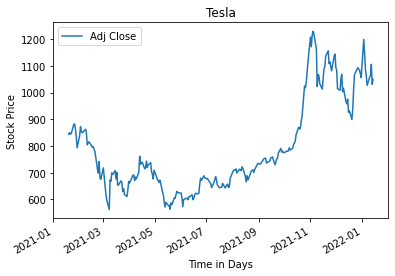

In [7]:
# Plot

Prices.plot(title = "Tesla")
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')

fig1 = plt.gcf()
fig1.savefig('Price(TSLA).pdf', format='pdf', dpi=1000)
fig1.savefig('Price(TSLA).eps', format='eps', dpi=1000)
plt.show()

In [8]:
import math
max_d = 0.05
V_start = 10000

def J(gamma):
    max_V = V_start
    Vk = V_start
    
    for k in range(N-1):
        dk = (max_V-Vk)/max_V
        Mk = (max_d-dk)/(1-dk)
        Vk1 = Vk * (1 + (gamma*Mk*float(return_for_Prices.iloc[k])))
        if Vk1 >= max_V:
            max_V = Vk1
        Vk = Vk1
    return math.log(Vk/V_start)/((N-1)**2)

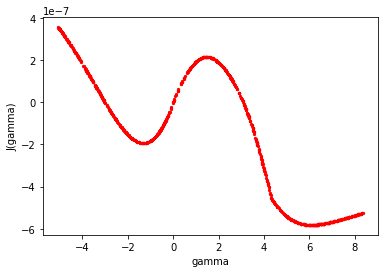

In [9]:
# 生成1000個區間內的gamma
r_list = []
Jr_list = []
for r in range(1000):
    r = np.random.uniform(min_gamma, max_gamma)
    r_list.append(r)
    Jr_list.append(J(r))
# 製作figure  
fig = plt.figure()   

# 圖表的設定
ax = fig.add_subplot(1, 1, 1)

# 散佈圖
ax.scatter(r_list, Jr_list, color='red', s=5)
plt.xlabel("gamma") 
plt.ylabel("J(gamma)")
fig2 = plt.gcf()
fig2.savefig('gamma(TSLA).pdf', format='pdf', dpi=1000)
fig2.savefig('gamma(TSLA).eps', format='eps', dpi=1000)
plt.show()

In [10]:
# 從模擬結果找最佳解
index = Jr_list.index(max(Jr_list))
print(max(Jr_list))
gamma_star005 = r_list[index]
print(gamma_star005)

3.5471979826279393e-07
-5.071437012033849


In [11]:
# cvxpy求最佳解(用classical Kelly)

r = cp.Variable()

sum_E = 0
for k in range(N-1):
    sum_E += cp.log(1 + (float(return_for_Prices.iloc[k])*r))
J_E = sum_E / N

constraints = [min_gamma <= r, r <= max_gamma]
obj = cp.Maximize(J_E)
prob = cp.Problem(obj, constraints)
prob.solve()
print(r.value)
cvx_result = r.value

print('Put the cvx_result into J function and we get:', J(cvx_result))
print('The diff against the gamma from DD:', J(cvx_result)-max(Jr_list))

# 得到的結果和上面模擬1000個gamma的結果(1.2309 vs -5.0714)
# 和Max DD的gamma放入J()結果有差(2.0866 vs 3.5472)

1.2309298229587349
Put the cvx_result into J function and we get: 2.086606350986985e-07
The diff against the gamma from DD: -1.4605916316409543e-07


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


max(Mk): 0.05
min(Mk): 0
max(d*): 0.04999973501297985
V_last: 10225.992824894773
return: 0.022599282489477263


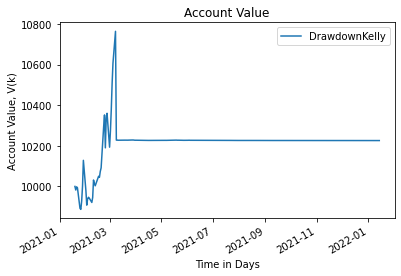

In [12]:
# Max Drawdown
Vk_list = [V_start]
max_V_ = V_start
Vk_ = V_start
max_Mk = 0
min_Mk = 0
max_d_star = 0

for k in range(N-1):
    dk = (max_V_-Vk_)/max_V_
    Mk = (max_d-dk)/(1-dk)
    Vk1_ = Vk_ * (1 + (gamma_star005*Mk*float(return_for_Prices.iloc[k])))
    Vk_list.append(Vk1_)
    if Vk1_ >= max_V_:
        max_V_ = Vk1_
    if Mk >= max_Mk:
        max_Mk = Mk
    if Mk <= min_Mk:
        min_Mk = Mk
    if dk >= max_d_star:
        max_d_star = dk
    Vk_ = Vk1_

# 時間和帳戶餘額的關係
Vk_data = pd.DataFrame.copy(Prices)
Vk_data = Vk_data.assign(DrawdownKelly = Vk_list)
Vk_data = Vk_data.drop('Adj Close', axis=1)

print('max(Mk):', max_Mk)
print('min(Mk):', min_Mk)
print('max(d*):', max_d_star)
print('V_last:', Vk_list[-1])
return_DD = (Vk_list[-1]-V_start)/V_start
print('return:', return_DD)

Vk_data.plot(title = "Account Value")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig3 = plt.gcf()
fig3.savefig('DrawdownKelly(TSLA).pdf', format='pdf', dpi=1000)
fig3.savefig('DrawdownKelly(TSLA).eps', format='eps', dpi=1000)
plt.show()

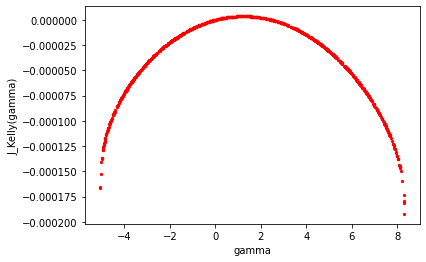

In [13]:
# Find gamma for classical Kelly

V_start_K = 10000

def J_Kelly(gamma):
    max_V_K = V_start_K
    Vk_K = V_start_K
    
    for k in range(N-1):
        dk = (max_V_K-Vk_K)/max_V_K
        Vk1_K = Vk_K * (1 + (gamma*float(return_for_Prices.iloc[k])))
        if Vk1_K >= max_V_K:
            max_V_K = Vk1_K
        Vk_K = Vk1_K
    return math.log(Vk_K/V_start_K)/((N-1)**2)
#gamma帶固定的值求得出結果

#生成1000個區間內的gamma
r_K_list = []
Jr_K_list = []
for r in range(1000):
    r = np.random.uniform(min_gamma, max_gamma)
    r_K_list.append(r)
    Jr_K_list.append(J_Kelly(r))
# 製作figure  
fig_K = plt.figure()   
#圖表的設定
ax_K = fig_K.add_subplot(1, 1, 1)
# 散佈圖
ax_K.scatter(r_K_list, Jr_K_list, color='red', s=5)
plt.xlabel("gamma") 
plt.ylabel("J_Kelly(gamma)")
fig5 = plt.gcf()
fig5.savefig('gammaKellyTSLA.pdf', format='pdf',dpi=fig.dpi, bbox_inches='tight')
fig5.savefig('gammaKellyTSLA.eps', format='eps',dpi=fig.dpi, bbox_inches='tight')
plt.show()

In [14]:
index_K = Jr_K_list.index(max(Jr_K_list))
print(max(Jr_K_list))
gamma_star_K = r_K_list[index_K]
print(gamma_star_K)
print(J(gamma_star_K))  # 得到的gamma代入Max DD
print('The diff against the gamma from DD:', J(gamma_star_K)-max(Jr_list))

3.5749789482254217e-06
1.236950289268016
2.0898385080787882e-07
The diff against the gamma from DD: -1.457359474549151e-07


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


            DrawdownKelly  ClassicalKelly
Date                                     
2021-01-19   10000.000000    10000.000000
2021-01-20    9982.285476    10086.413321
2021-01-21    9997.988410    10006.312935
2021-01-22    9993.056796    10030.482294
2021-01-25    9892.167123    10531.084538
2021-01-26    9886.996203    10564.952646
2021-01-27    9929.067375    10284.818102
2021-01-28   10001.410575     9861.867111
2021-01-29   10128.604355     9250.059363
2021-02-01    9978.815213     9917.367549
max(d*): 0.43747706967747707
8.749587764093324 times
V_last: 12526.07337261238
1.2249249131212132 times
return: 0.25260733726123796
11.177670679538506 times
10.743874756888742 times
3.928262988928382 times


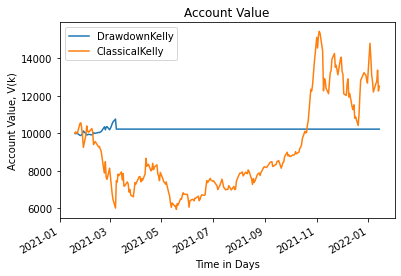

In [15]:
# Classial Kelly
Vk_K_list_ = [V_start_K]
max_V_K_ = V_start_K
Vk_K_ = V_start_K
max_d_K_star = 0

for k in range(N-1):
    dk = (max_V_K_-Vk_K_)/max_V_K_
    Vk1_K_ = Vk_K_ * (1 + (gamma_star_K*float(return_for_Prices.iloc[k])))
    Vk_K_list_.append(Vk1_K_)
    if Vk1_K_ >= max_V_K_:
        max_V_K_ = Vk1_K_
    if dk >= max_d_K_star:
        max_d_K_star = dk
    Vk_K_ = Vk1_K_

Vk_data = Vk_data.assign(ClassicalKelly = Vk_K_list_)
print(Vk_data.head(10))
print('max(d*):', max_d_K_star)
print(max_d_K_star/max_d_star, 'times')
print('V_last:', Vk_K_list_[-1])
print(Vk_K_list_[-1]/Vk_list[-1], 'times')
return_K = (Vk_K_list_[-1]-V_start_K)/V_start_K
print('return:', return_K)
print(return_K/return_DD, 'times')
print((price_list[-1]-price_list[0])/(price_list[0]*return_DD), 'times')
print(float(max_X)/max_d_star, 'times')

Vk_data.plot(title = "Account Value")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig4 = plt.gcf()
fig4.savefig('AccountValue(Kelly)(TSLA).pdf', format='pdf', dpi=1000)
fig4.savefig('AccountValue(Kelly)(TSLA).eps', format='eps', dpi=1000)
plt.show()

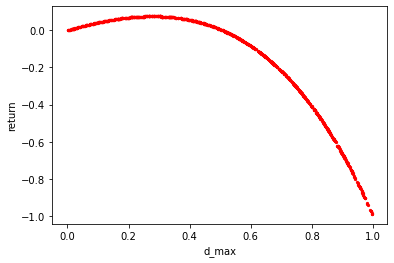

In [16]:
# 畫expected drawdown和expected return的關係圖
# gamma用d_max=0.05算出來的結果(-5.07左右)

def J_return005(d):
    max_V = V_start
    Vk = V_start
    Vk_list = []
    for k in range(N-1):
        dk = (max_V-Vk)/max_V
        Mk = (d-dk)/(1-dk)
        Vk1 = Vk * (1 + (gamma_star005*Mk*float(return_for_Prices.iloc[k])))
        Vk_list.append(Vk1)
        if Vk1 >= max_V:
            max_V = Vk1
        Vk = Vk1
    throughtout_return = (Vk_list[-1]-V_start)/V_start
    return throughtout_return

#生成1000個區間內的d_max
return_list = []
d_list = []
for d in range(1000):
    d = np.random.uniform(0, 1)
    d_list.append(d)
    return_list.append(J_return005(d))

# Plot 
fig_rd005 = plt.figure()
ax_rd005 = fig_rd005.add_subplot(1, 1, 1)
ax_rd005.scatter(d_list, return_list, color='red', s=5)
plt.xlabel("d_max") 
plt.ylabel("return")
fig5 = plt.gcf()
fig5.savefig('d&returnTSLA_0.05.pdf', format='pdf', dpi=1000)
fig5.savefig('d&returnTSLA_0.05.eps', format='eps', dpi=1000)
plt.show()

In [17]:
# 從模擬結果找最佳解

index_d = return_list.index(max(return_list))
print('largest return:', max(return_list))
d_star = d_list[index_d]
print('d_max:', d_star)

largest return: 0.07528985622366727
d_max: 0.27814551604479587


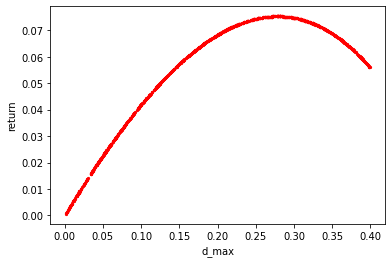

In [18]:
# 畫expected drawdown和expected return的關係圖
# gamma用d_max=0.05算出來的結果(-5.07左右)
# 把0~0.4這段切更細

#生成1000個區間內的d_max
return_list = []
d_list = []
for d in range(1000):
    d = np.random.uniform(0, 0.4)
    d_list.append(d)
    return_list.append(J_return005(d))

# Plot
fig_rd0to04 = plt.figure()
ax_rd0to04 = fig_rd0to04.add_subplot(1, 1, 1)
ax_rd0to04.scatter(d_list, return_list, color='red', s=5)
plt.xlabel("d_max") 
plt.ylabel("return")
fig6 = plt.gcf()
fig6.savefig('d&returnTSLA_0.05detail.pdf', format='pdf', dpi=1000)
fig6.savefig('d&returnTSLA_0.05detail.eps', format='eps', dpi=1000)
plt.show()

In [19]:
# 從模擬結果找最佳解

index_d = return_list.index(max(return_list))
print('largest return:', max(return_list))
d_star = d_list[index_d]
print('d_max:', d_star)

largest return: 0.07528992473738508
d_max: 0.27843682811070214


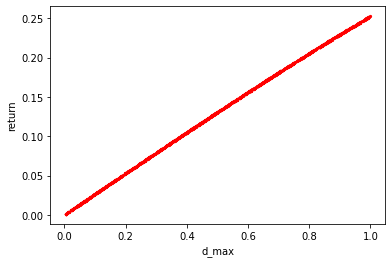

In [34]:
# 畫expected drawdown和expected return的關係圖
# gamma用cvxpy算出來的結果(1.23左右)

def J_returncvx(d):
    max_V = V_start
    Vk = V_start
    Vk_list = []
    for k in range(N-1):
        dk = (max_V-Vk)/max_V
        Mk = (d-dk)/(1-dk)
        Vk1 = Vk * (1 + (cvx_result*Mk*float(return_for_Prices.iloc[k])))
        Vk_list.append(Vk1)
        if Vk1 >= max_V:
            max_V = Vk1
        Vk = Vk1
    throughtout_return = (Vk_list[-1]-V_start)/V_start
    return throughtout_return

#生成1000個區間內的d_max
return_list = []
d_list = []
for d in range(1000):
    d = np.random.uniform(0, 1)
    d_list.append(d)
    return_list.append(J_returncvx(d))

# Plot
fig_rdcvx = plt.figure()
ax_rdcvx = fig_rdcvx.add_subplot(1, 1, 1)
ax_rdcvx.scatter(d_list, return_list, color='red', s=5)
plt.xlabel("d_max") 
plt.ylabel("return")
fig7 = plt.gcf()
fig7.savefig('d&returnTSLA_cvxpy.pdf', format='pdf', dpi=1000)
fig7.savefig('d&returnTSLA_cvxpy.eps', format='eps', dpi=1000)
plt.show()

In [35]:
# 從模擬結果找最佳解

index_d = return_list.index(max(return_list))
print('largest return:', max(return_list))
d_star = d_list[index_d]
print('d_max:', d_star)

largest return: 0.25230276358216014
d_max: 0.9986499374631397


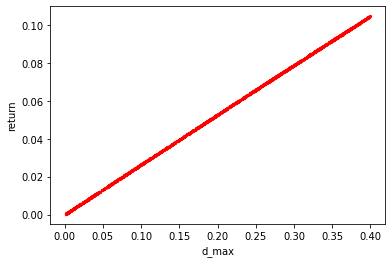

In [22]:
# 畫expected drawdown和expected return的關係圖
# gamma用cvxpy算出來的結果(1.23左右)
# 細分0~0.4

#生成1000個區間內的d_max
return_list = []
d_list = []
for d in range(1000):
    d = np.random.uniform(0, 0.4)
    d_list.append(d)
    return_list.append(J_returncvx(d))

# Plot
fig_rdcvx075to1 = plt.figure()
ax_rdcvx075to1 = fig_rdcvx075to1.add_subplot(1, 1, 1)
ax_rdcvx075to1.scatter(d_list, return_list, color='red', s=5)
plt.xlabel("d_max") 
plt.ylabel("return")
fig8 = plt.gcf()
fig8.savefig('d&returnTSLA_cvxpydetail.pdf', format='pdf', dpi=1000)
fig8.savefig('d&returnTSLA_cvxpydetail.eps', format='eps', dpi=1000)
plt.show()

In [23]:
# 從模擬結果找最佳解

index_d = return_list.index(max(return_list))
print('largest return:', max(return_list))
d_star = d_list[index_d]
print('d_max:', d_star)

largest return: 0.10466877351780422
d_max: 0.39925687052044684


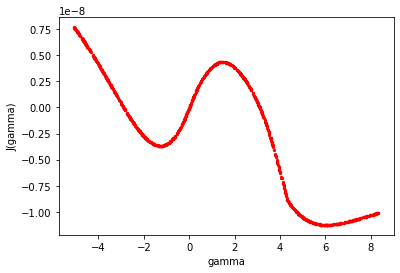

7.657673374961698e-09
-5.0772992202360685


In [24]:
# 把容許的最大跌幅改成0.001

max_d = 0.001
r_list = []
Jr_list = []
for r in range(1000):
    r = np.random.uniform(min_gamma, max_gamma)
    r_list.append(r)
    Jr_list.append(J(r))

# Plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(r_list, Jr_list, color='red', s=5)
plt.xlabel("gamma") 
plt.ylabel("J(gamma)")
fig2_1 = plt.gcf()
fig2_1.savefig('gammaTSLA_0.001.pdf', format='pdf', dpi=1000)
fig2_1.savefig('gammaTSLA_0.001.eps', format='eps', dpi=1000)
plt.show()

# 從模擬結果找最佳解
index = Jr_list.index(max(Jr_list))
print(max(Jr_list))
gamma_star0001 = r_list[index]
print(gamma_star0001)

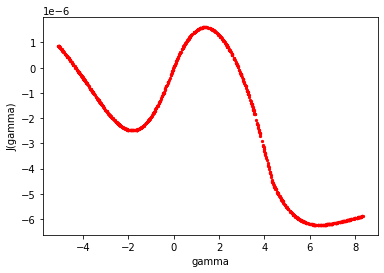

1.60475325876486e-06
1.3704523460581184


In [26]:
# 把容許的最大跌幅改成0.4

max_d = 0.4
r_list = []
Jr_list = []
for r in range(1000):
    r = np.random.uniform(min_gamma, max_gamma)
    r_list.append(r)
    Jr_list.append(J(r))

# Plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(r_list, Jr_list, color='red', s=5)
plt.xlabel("gamma") 
plt.ylabel("J(gamma)")
fig2_2 = plt.gcf()
fig2_2.savefig('gammaTSLA_0.4.pdf', format='pdf', dpi=1000)
fig2_2.savefig('gammaTSLA_0.4.eps', format='eps', dpi=1000)
plt.show()

# 從模擬結果找最佳解
index = Jr_list.index(max(Jr_list))
print(max(Jr_list))
gamma_star04 = r_list[index]
print(gamma_star04)

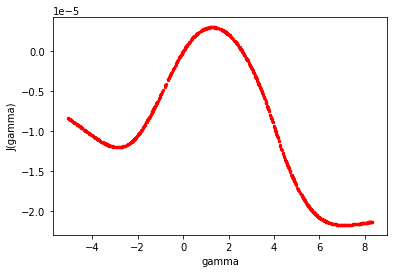

2.9690357935118574e-06
1.292663441122209


In [27]:
# 把容許的最大跌幅改成0.8

max_d = 0.8
r_list = []
Jr_list = []
for r in range(1000):
    r = np.random.uniform(min_gamma, max_gamma)
    r_list.append(r)
    Jr_list.append(J(r))

# Plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(r_list, Jr_list, color='red', s=5)
plt.xlabel("gamma") 
plt.ylabel("J(gamma)")
fig2_3 = plt.gcf()
fig2_3.savefig('gammaTSLA_0.8.pdf', format='pdf', dpi=1000)
fig2_3.savefig('gammaTSLA_0.8.eps', format='eps', dpi=1000)
plt.show()

# 從模擬結果找最佳解
index = Jr_list.index(max(Jr_list))
print(max(Jr_list))
gamma_star08 = r_list[index]
print(gamma_star08)

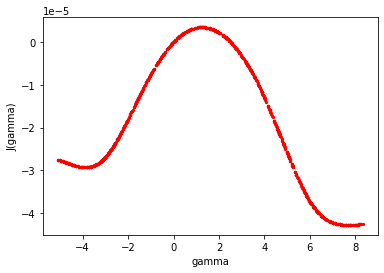

3.4275060554768828e-06
1.253650407406238


In [28]:
# 把容許的最大跌幅改成0.95

max_d = 0.95
r_list = []
Jr_list = []
for r in range(1000):
    r = np.random.uniform(min_gamma, max_gamma)
    r_list.append(r)
    Jr_list.append(J(r))

# Plot  
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(r_list, Jr_list, color='red', s=5)
plt.xlabel("gamma") 
plt.ylabel("J(gamma)")
fig2_4 = plt.gcf()
fig2_4.savefig('gammaTSLA_0.95.pdf', format='pdf', dpi=1000)
fig2_4.savefig('gammaTSLA_0.95.eps', format='eps', dpi=1000)
plt.show()

# 從模擬結果找最佳解
index = Jr_list.index(max(Jr_list))
print(max(Jr_list))
gamma_star095 = r_list[index]
print(gamma_star095)

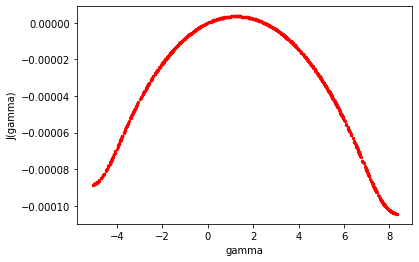

3.572080237660423e-06
1.226042821658858


In [29]:
# 把容許的最大跌幅改成0.999

max_d = 0.999
r_list = []
Jr_list = []
for r in range(1000):
    r = np.random.uniform(min_gamma, max_gamma)
    r_list.append(r)
    Jr_list.append(J(r))

# 製作figure  
fig = plt.figure()   

# 圖表的設定
ax = fig.add_subplot(1, 1, 1)

# 散佈圖
ax.scatter(r_list, Jr_list, color='red', s=5)
plt.xlabel("gamma") 
plt.ylabel("J(gamma)")
fig2_5 = plt.gcf() # 'get current figure'
fig2_5.savefig('gammaTSLA_0.999.pdf', format='pdf', dpi=1000)
fig2_5.savefig('gammaTSLA_0.999.eps', format='eps', dpi=1000)
plt.show()

# 從模擬結果找最佳解
index = Jr_list.index(max(Jr_list))
print(max(Jr_list))
gamma_star0999 = r_list[index]
print(gamma_star0999)

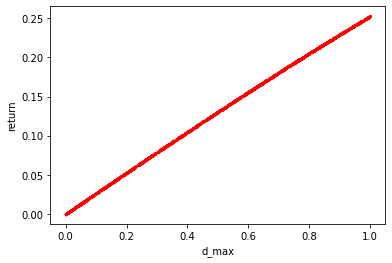

In [30]:
# 畫expected drawdown和expected return的關係圖
# gamma用d_max=0.999算出來的結果(1.23左右)

def J_return0999(d):
    max_V = V_start
    Vk = V_start
    Vk_list = []
    for k in range(N-1):
        dk = (max_V-Vk)/max_V
        Mk = (d-dk)/(1-dk)
        Vk1 = Vk * (1 + (gamma_star0999*Mk*float(return_for_Prices.iloc[k])))
        Vk_list.append(Vk1)
        if Vk1 >= max_V:
            max_V = Vk1
        Vk = Vk1
    throughtout_return = (Vk_list[-1]-V_start)/V_start
    return throughtout_return

#生成1000個區間內的d_max
return_list = []
d_list = []
for d in range(1000):
    d = np.random.uniform(0, 1)
    d_list.append(d)
    return_list.append(J_return0999(d))

# Plot
fig_rd0999 = plt.figure()   
ax_rd0999 = fig_rd0999.add_subplot(1, 1, 1)
ax_rd0999.scatter(d_list, return_list, color='red', s=5)
plt.xlabel("d_max") 
plt.ylabel("return")
fig9 = plt.gcf()
fig9.savefig('d&returnTSLA_0.999.pdf', format='pdf', dpi=1000)
fig9.savefig('d&returnTSLA_0.999.eps', format='eps', dpi=1000)
plt.show()

In [31]:
# 從模擬結果找最佳解

index_d = return_list.index(max(return_list))
print('largest return:', max(return_list))
d_star = d_list[index_d]
print('d_max:', d_star)

largest return: 0.25256573921552333
d_max: 0.9998100358394338


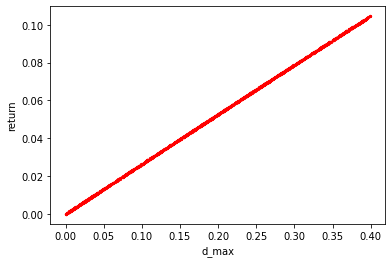

In [32]:
# 畫expected drawdown和expected return的關係圖
# gamma用d_max=0.999算出來的結果(1.23左右)
# 細分0~0.4

#生成1000個區間內的d_max
return_list_1 = []
d_list_1 = []
for d in range(1000):
    d = np.random.uniform(0, 0.4)
    d_list_1.append(d)
    return_list_1.append(J_return0999(d))

# Plot
fig_rd0999_1 = plt.figure()   
ax_rd0999_1 = fig_rd0999_1.add_subplot(1, 1, 1)
ax_rd0999_1.scatter(d_list_1, return_list_1, color='red', s=5)
plt.xlabel("d_max") 
plt.ylabel("return")
fig9_1 = plt.gcf()
fig9_1.savefig('d&returnTSLA_0.999detail.pdf', format='pdf', dpi=1000)
fig9_1.savefig('d&returnTSLA_0.999detail.eps', format='eps', dpi=1000)
plt.show()

In [33]:
# 從模擬結果找最佳解

index_d_1 = return_list_1.index(max(return_list_1))
print('largest return:', max(return_list_1))
d_star_1 = d_list_1[index_d_1]
print('d_max:', d_star_1)

largest return: 0.10446325164705758
d_max: 0.39883504273435616
